# ORIE 4580/5580/5581 Assignment 3

#### Students: Shiyu Chen (sc3283) and Mingyi Yao (my533)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Friday September 22, at 11.59am on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/56826#:~:text=Assignments-,Assignments,-Assignments%20Module%20publish). Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Bard or ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**. You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [1]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
%matplotlib inline

___
___

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats\ldots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) { mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) { mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) { mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


## Linear Congruential Generators

A more useful method to generate pseudorandom numbers is via *linear congruential generators*. To study this, we first write a function to generate pseudorandom numbers $(u_1,u_2,\ldots)$ according to the following rule: we start with a *seed* $x_0$, and then we generate the $n^{th}$ sample $u_n$ using the following update rule
\begin{align*}
    u_n &= \frac{x_n+1}{m+1} \\
	x_{n+1}  &=  (ax_n + c) \mbox{ mod }  m
\end{align*}
Note: This returns $u_i\in\left\{\frac{1}{m+1},\frac{2}{m+1},\ldots,\frac{m}{m+1}\right\}$. If instead we use  $u_n = \frac{x_n}{m}$, then we get $u_i\in\left\{0,\frac{1}{m},\frac{2}{m},\ldots,\frac{m-1}{m}\right\}$

Inputs: Length $n$, modulus $m$, multiplier $a$, increment $c$, seed $x_0$

___
**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).
___

In [ ]:
# Functions to visualize LCG sequence on clock (see demo notebook)
def plot_clock_face(m, fig, annotate=False):
    """
    Plot points on a unit circle representing the LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    annotate (bool): Whether to annotate points with their index.
    Returns:
    None
    """
    # Plot m points on the unit circle
    for i in range(m):
        theta = 2.0 * np.pi * i / m
        plt.plot(np.sin(theta), np.cos(theta), 'rs', markersize = 10)
        if annotate:
            plt.annotate(str(i), (np.pi/2 - theta, 1.05), xycoords='polar')

def plot_clock_path(m, x, fig, color='y'):
    """
    Plot the path of an LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    x (numpy.ndarray): The LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    color (str): The color for the path.

    Returns:
    None
    """
    # Plot the seed node
    theta_0 = 2.0 * np.pi * (x[0] * (m + 1) - 1) / m
    plt.plot(np.sin(theta_0), np.cos(theta_0), 'gs', markersize = 10)

    # Plot the path of the LCG sequence
    for i in range(len(x) - 1):
        theta_start = 2.0 * np.pi * (x[i] * (m + 1) - 1) / m
        theta_end = 2.0 * np.pi * (x[i + 1] * (m + 1) - 1) / m
        x_start = np.sin(theta_start)
        y_start = np.cos(theta_start)
        del_x = np.sin(theta_end) - np.sin(theta_start)
        del_y = np.cos(theta_end) - np.cos(theta_start)
        if abs(del_x) > 0 or abs(del_y) > 0:
            plt.arrow(x_start, y_start, del_x, del_y,
                      length_includes_head=True, head_width=0.05, head_length=0.1, fc=color, ec=color)



In [ ]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (see demo notebook)
def LCG(n, m=2**31-1, a=1103515245, c=12345, seed=1):
    """
    Generate a pseudorandom sequence using a Linear Congruential Generator (LCG).

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    m (int): The modulus value (default is 2^31-1, following glibc specifications).
    a (int): The multiplier value (default is 1103515245, following glibc specifications).
    c (int): The increment value (default is 12345, following glibc specifications).
    seed (int): The initial seed value (default is 1).

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    x = seed
    for i in range(n):
        # Calculate the pseudorandom number
        output[i] = x+1

        # Update the LCG state using the specified parameters
        x = (a * x + c) % m

    return output


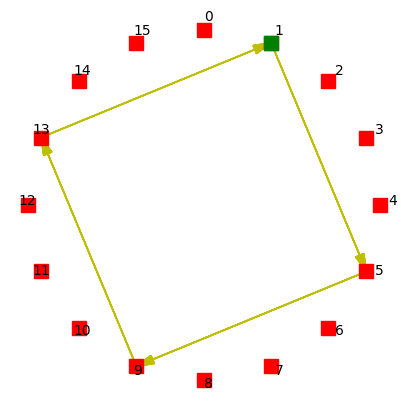

In [ ]:
# Ans
# For X
m = 16
a = 5
c = 0
seed = 1

fig = plt.figure(figsize=(5,5))
x = LCG(n=m+1,m=m,a=a,c=0,seed = seed)

plot_clock_face(m,fig,annotate = True)
plot_clock_path(m,x,fig)
#plt.axis('equal')
plt.axis('off')
plt.show()

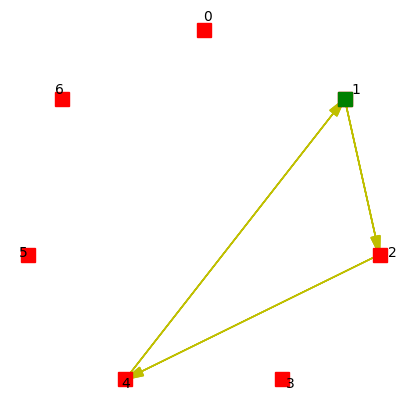

In [ ]:
# For Y
m = 7
a = 2
c = 0
seed = 1

fig = plt.figure(figsize=(5,5))
y = LCG(n=m+1,m=m,a=a,c=c,seed = seed)

plot_clock_face(m,fig,annotate = True)
plot_clock_path(m,y,fig)
#plt.axis('equal')
plt.axis('off')
plt.show()

___
**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.
___

In [ ]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (see demo notebook)
def LCG_combined(n, m_x=2**31-1, m_y=2**31-1, m_z=2**31-1, a_x=1103515245, a_y=1103515245, seed=1):
    """
    Generate a pseudorandom sequence using a Linear Congruential Generator (LCG).

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    m (int): The modulus value (default is 2^31-1, following glibc specifications).
    a (int): The multiplier value (default is 1103515245, following glibc specifications).
    c (int): The increment value (default is 12345, following glibc specifications).
    seed (int): The initial seed value (default is 1).

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    x = seed
    y = seed
    z = seed
    for i in range(n):
        # Calculate the pseudorandom number
        output[i] = (x + y + 1) % m_z

        # Update the LCG state using the specified parameters
        x = (a_x * x) % m_x
        y = (a_y * y) % m_y


    return output


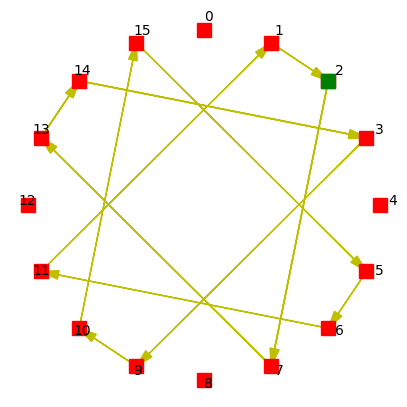

In [ ]:
# For Z
m_x = 16
a_x = 5
m_y = 7
a_y = 2
m_z = 16
seed = 1

fig = plt.figure(figsize=(5,5))
z = LCG_combined(n=m_z+1,m_x=m_x,a_x=a_x,m_y=m_y,a_y=a_y,m_z=m_z,seed = seed)

plot_clock_face(m_z,fig,annotate = True)
plot_clock_path(m_z,z,fig)
#plt.axis('equal')
plt.axis('off')
plt.show()

___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.

From the clock path plot of $x_n$, $y_n$ and $z_n$, we can obtain their periods:

for $x_n$, it has peiod 4

for $y_n$, it has peiod 3

for $z_n$, it has peiod 12

___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___

### Ans.

$F'(y)=
	\begin{cases}
	0 & \mbox{for $y = 0$},\\
	y & \mbox{for $0 \leq y < \frac{1}{2}$}, \\
	1 & \mbox{for $y > \frac{1}{2}$}
	 \end{cases}$

___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

Firstly, find the cdf of Geometric distribution. \\
$F(k)=\sum_{i=1}^k p(i)= \sum_{i=1}^k p(1-p)^{i-1}= 1-(1-p)^k$ \\

Then, equate u with cdf function and obtain: \\
$k = \frac{log(1-u)}{log(1-p)}$ \\
Next, we need to first generate 1000 uniform distributed random variable u,
then, we plug the value of u into the equation.

(array([422.,   0., 261.,   0.,   0., 133.,   0.,  89.,   0.,   0.,  45.,
          0.,  20.,   0.,   0.,  10.,   0.,   7.,   0.,   0.,   5.,   0.,
          3.,   0.,   0.,   3.,   0.,   0.,   0.,   2.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ,
         5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,  8.6,  9. ,  9.4,
         9.8, 10.2, 10.6, 11. , 11.4, 11.8, 12.2, 12.6, 13. ]),
 <BarContainer object of 30 artists>)

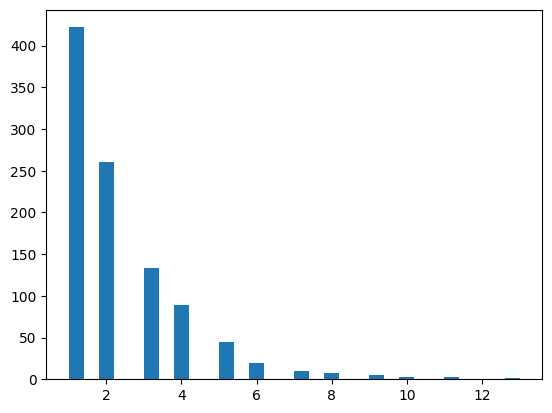

In [ ]:
p = 0.42
U = np.random.rand(1000)  # Generate uniform random variables
k = np.ceil(np.log(1 - U) / np.log(1 - p))
plt.hist(k, bins = 'auto')

___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.

Firstly, calculate the cdf of f(x), which is

$F(x) =
	\begin{cases}
		e^{x-2}-e^{-2} & \text{for }0 \leq x \leq 2, \\
		1- e^{-x} & \text{for }x > 2
	\end{cases}$

(array([ 24.,  27.,  26.,  32.,  47.,  50.,  49.,  59.,  93.,  94., 120.,
        133., 125.,  19.,  15.,  12.,   9.,  11.,   7.,   9.,   7.,   7.,
          2.,   3.,   1.,   5.,   1.,   3.,   1.,   1.,   0.,   1.,   1.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   2.]),
 array([1.08611815e-03, 1.57087078e-01, 3.13088037e-01, 4.69088997e-01,
        6.25089956e-01, 7.81090916e-01, 9.37091875e-01, 1.09309283e+00,
        1.24909379e+00, 1.40509475e+00, 1.56109571e+00, 1.71709667e+00,
        1.87309763e+00, 2.02909859e+00, 2.18509955e+00, 2.34110051e+00,
        2.49710147e+00, 2.65310243e+00, 2.80910339e+00, 2.96510435e+00,
        3.12110531e+00, 3.27710627e+00, 3.43310723e+00, 3.58910819e+00,
        3.74510915e+00, 3.90111011e+00, 4.05711107e+00, 4.21311203e+00,
        4.36911299e+00, 4.52511394e+00, 4.68111490e+00, 4.83711586e+00,
        4.99311682e+00, 5.14911778e+00, 5.30511874e+00, 5.46111970e+00,
        5.61712066e+00, 5.77312162e+00, 5.92912258e+00, 6.08

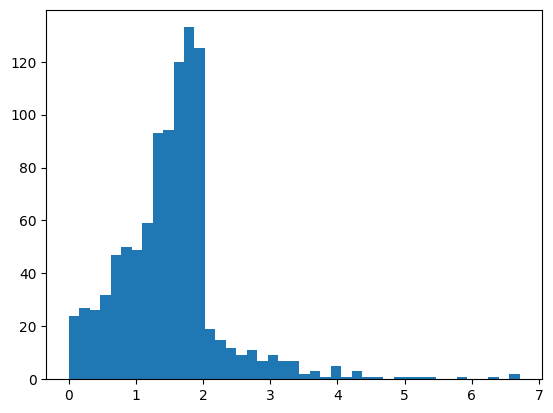

In [ ]:
U = np.random.rand(1000)
x = np.zeros(1000)
for i in range(len(U)):
  if U[i] > 1 - (math.exp(-2)):
    x[i] = math.log(1/(1 - U[i]))
  else:
    x[i] = 2 + math.log(math.exp(-2) + U[i])
plt.hist(x, bins='auto')

___
___

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

___
**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

___

### Ans.


Since this is a bound region (within inerval [0,1]). Thus, we can use the rectangle method. Firstly, find M, the maximum value during that region is $\frac{13}{4}$. Then our strategy is: \\

1: generae uniformly distributed variable, $U_{1}$ and $U_{2}$. \\
2: set $Z_{1} = 0+(1-0)*U_{1}$ and $Z_{2} = M*U_{2}$. \\
3: if $Z_{2} \leq f(Z_{1})$, then, return $X_{0} = Z_{1}$; else, reject and repeat.

In [ ]:
def ar_generator(m):
  U1, U2 = np.random.rand(2)
  Z1 = U1
  Z2 = m*U2
  while Z2 > (5*Z1**4+4*Z1**3+3*Z1**2+1)/4:
    U1, U2 = np.random.rand(2)
    Z1 = U1
    Z2 = m*U2
  return Z1

In [ ]:
ar_generator(13/4)

0.8295721226882983

___
**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?
___

### Ans.
Expected number of point needed for a single accept is: \\
Since $P(a\ point\ is\ accepted) = \frac{1}{M(b-a)}$ \\
E[num needed] = M(b-a) \\
Thus, in our case, it is $\frac{13}{4}$.

___
**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.
___


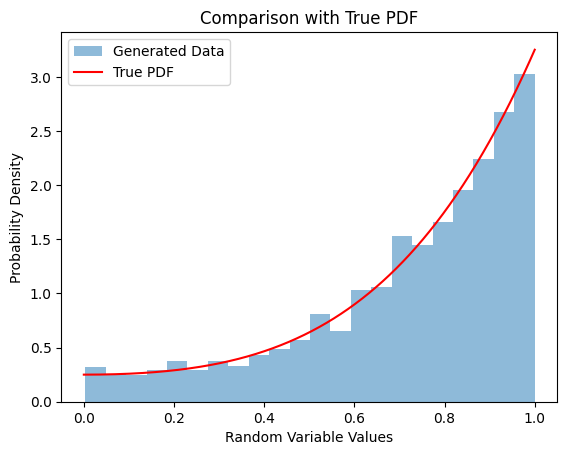

In [ ]:
X_var = [ar_generator(13/4)]
while len(X_var) < 2500:
  X_var.append(ar_generator(13/4))

def true_pdf(x):
    return (5*x**4 + 4*x**3+3*x**2+1)/4

plt.hist(X_var, bins='auto', density=True, alpha=0.5, label='Generated Data')
x = np.linspace(0, 1, 2500)
plt.plot(x, true_pdf(x), 'r', label='True PDF')
plt.legend()
plt.xlabel('Random Variable Values')
plt.ylabel('Probability Density')
plt.title('Comparison with True PDF')
plt.show()


___
___

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a $\mathcal{N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

___

**(a)** First, suppose we choose the proposal distribution to be a \emph{Laplace} (i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.
___

To generate samples from a Laplace distribution with probability density function (pdf) $g(x)=\frac{1}{2} e^{-|x|}$.

1. Generate a random variable $U$ from a uniform distribution in the range $(0,1)$.
2. Apply the inverse transform method to $U$ to obtain a sample from the Laplace distribution.

The CDF of the Laplace distribution is given by:
$$
F(x)= \begin{cases}\frac{1}{2} e^x & \text { if } x<0 \\ 1-\frac{1}{2} e^{-x} & \text { if } x \geq 0\end{cases}
$$

Therefore, we can compute the inverse F functions as follows:

$$
F^{-1}(u)= \begin{cases}\ln (2 u) & \text { if } u \leq 0.5 \\ -\ln (2(1-u)) & \text { if } u>0.5\end{cases}
$$

In [ ]:
def laplace_inverse_transform(n):
    U = np.random.rand(n)
    samples = np.zeros(n)
    for i in range(n):
        u = U[i]
        if u <= 0.5:
            # Inverse transform for u <= 0.5
            x = np.log(2 * u)
        else:
            # Inverse transform for u > 0.5
            x = -np.log(2 * (1 - u))
    return samples

laplace_inverse_transform(10)

array([ 0.12186877,  5.13856077,  3.40201123, -0.42833214,  0.33056923,
       -0.65411938,  1.94827303,  0.3433858 ,  1.38034112, -2.94634033])

___
**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in\mathbb{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim\mathcal{N}(0,1)$, and compute the expected number of samples needed for generating each sample.
___

### Ans.

Descriptions: \\
1: choose $k$ such that $k \geq max_x [\frac{f(x)}{g(x)}]$.

2: sample $X$ from $g(x)$ (i.e. $X$ has pdf $g(x)$).

3: if $f(x) \leq k*g(x)$, then accept X; else, reject $X$ and generate new $X$ from $g(x)$.


for $x \leqslant 0$ :
$$
\begin{aligned}
& g(x)=\frac{1}{2} e^x \\
& \max _{x \leq 0} \frac{f(x)}{g(x)}\\
&=\max _{x \leq 0} \frac{e^{-\frac{x^2}{2}} / \sqrt{2 \pi}}{\frac{1}{2} e^x} \\
& =\max _{x \leq 0} \frac{2}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}-x} \\
& =\frac{2}{\sqrt{2 \pi}} e^{-\frac{1}{2}+1} \\
& =1.3154 \\
&
\end{aligned}
$$
for $x \geqslant 0$ :
$$
\begin{aligned}
&g(x)=\frac{1}{2} e^{-x} \\
& \max _{x \geqslant 0} \frac{f(x)}{g(x)}\\
& =\max _{x \geqslant 0} \frac{e^{-\frac{x^2}{2}} / \sqrt{2 \pi}}{\frac{1}{2} e^{-x}} \\
& =\max _{x \geqslant 0} \frac{2}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}+x} \\
& =\max _{x \geqslant 0} \frac{2}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}+x} \\
& =\frac{2}{\sqrt{2 \pi}} e^{1-\frac{1}{2}}=\frac{2}{\sqrt{2 \pi}} e^{\frac{1}{2}}=1.3154
\end{aligned}
$$

In [ ]:
def laplace_inverse_transform(n):
    U = np.random.rand(n)
    samples = np.zeros(n)
    for i in range(n):
        u = U[i]
        if u <= 0.5:
            # Inverse transform for u <= 0.5
            x = np.log(2 * u)
        else:
            # Inverse transform for u > 0.5
            x = -np.log(2 * (1 - u))

    return samples

In [3]:
# choose k = 2/np.sqrt(2*np.pi)*np.exp(1/2)
def f(x):
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)

def g(x):
    return 0.5 * np.exp(-np.abs(x))

def acceptance_rejection_sampling(n_samples):
    samples = []
    k = np.sqrt(2 / np.pi) * np.exp(0.5)
    tmp = 0
    # actually, we need to generate two random variables, first from g(), next from uniform distribution
    while len(samples) < n_samples:
        candidate = np.random.laplace(scale=1.0 / np.sqrt(2), size=1)[0]
        if np.random.rand() <= f(candidate) / (k * g(candidate)):  # use uniformly distributed random variable as their decision criteria
            samples.append(candidate)
    return np.array(samples)


$P($ acceptance $)=\int \frac{f(x)}{k \cdot g(x)} \cdot g(x) d x$ = $\frac{1}{k}$

E[num needed ] = 1/$P($ acceptance $)$

In [ ]:
k = np.sqrt(2 / np.pi) * np.exp(0.5)
print('the number needed is', k)

the number needed is 1.315489246958914


___
**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.
___

In [13]:
def acceptance_rejection_sampling_modified(n_samples):
    samples = []
    k = np.sqrt(2 / np.pi) * np.exp(0.5)
    uniform_samples_needed = []

    while len(samples) < n_samples:
        candidate = np.random.laplace(scale=1.0 / np.sqrt(2), size=1)[0]
        tmp = np.random.rand()
        uniform_samples_needed.append(1)

        while tmp > f(candidate) / (k * g(candidate)):
            candidate = np.random.laplace(scale=1.0 / np.sqrt(2), size=1)[0]
            tmp = np.random.rand()
            uniform_samples_needed[-1] += 1

        samples.append(candidate)

    return np.array(samples), uniform_samples_needed

X, uni_needed = acceptance_rejection_sampling_modified(1000)

(array([0.00952584, 0.        , 0.01428876, 0.00952584, 0.01905167,
        0.03810335, 0.05715502, 0.08096961, 0.09049545, 0.15717631,
        0.23814592, 0.30006386, 0.42866266, 0.54773562, 0.42866266,
        0.53820979, 0.39532223, 0.40961099, 0.32387846, 0.20004258,
        0.15717631, 0.12383588, 0.04286627, 0.06668086, 0.03810335,
        0.03810335, 0.00952584]),
 array([-3.19227436, -2.98231905, -2.77236374, -2.56240844, -2.35245313,
        -2.14249783, -1.93254252, -1.72258722, -1.51263191, -1.30267661,
        -1.0927213 , -0.88276599, -0.67281069, -0.46285538, -0.25290008,
        -0.04294477,  0.16701053,  0.37696584,  0.58692114,  0.79687645,
         1.00683176,  1.21678706,  1.42674237,  1.63669767,  1.84665298,
         2.05660828,  2.26656359,  2.47651889]),
 <BarContainer object of 27 artists>)

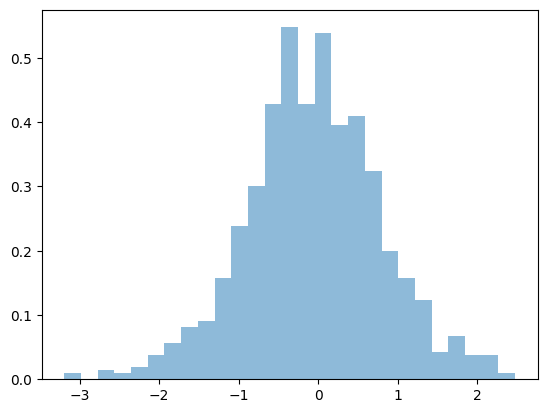

In [14]:
plt.hist(X, bins='auto', density=True, alpha=0.5, label='Generated Laplace Distribution Samples')

In [15]:
import scipy.stats as stats
uni_needed = [x*1000 for x in uni_needed]
average_uniform_samples = np.mean(uni_needed)
ci = stats.t.interval(0.95, len(uni_needed) - 1, loc=np.mean(uni_needed), scale=stats.sem(uni_needed))
print('mean number of uniformly distributed random variables is:', average_uniform_samples)
print('Confidence Inerval is:', ci)

mean number of uniformly distributed random variables is: 1252.0
Confidence Inerval is: (1216.6331394811616, 1287.3668605188384)


___
**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.
___

(-15.0, 15.0)

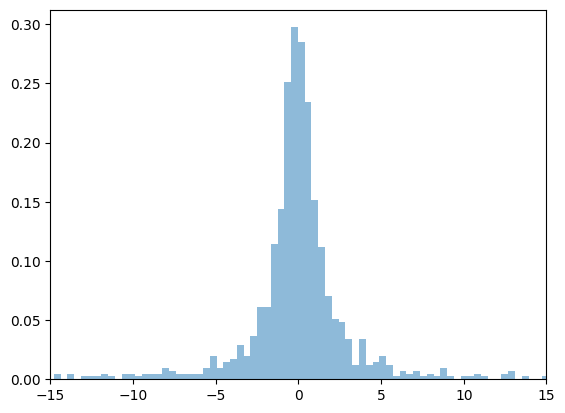

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Inverse CDF (quantile function) of the Cauchy distribution
def cauchy_inverse_cdf(y):
    return np.tan(np.pi * (y - 0.5))

# Number of samples to generate
n_samples = 1000

# Generate uniform random numbers in the range (0, 1)
uniform_samples = np.random.rand(n_samples)

# Use the inverse CDF to transform uniform samples to Cauchy samples
cauchy_samples = cauchy_inverse_cdf(uniform_samples)

# Plot the histogram of Cauchy samples
plt.hist(cauchy_samples, bins='auto', density=True, alpha=0.5, label='Cauchy Samples')
plt.xlim(-15, 15)
# x = np.linspace(-10, 10, 1000)  # Range for the PDF plot
# pdf = 1 / (np.pi * (1 + x**2))  # PDF of the Cauchy distribution
# plt.plot(x, pdf, 'r', label='Cauchy PDF')
# plt.legend()
# plt.xlabel('Random Variable Values')
# plt.ylabel('Probability Density')
# plt.title('Histogram of Cauchy Samples')
# plt.show()


___
**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.
___

### Ans.

In [16]:
# firstly, recompute the value of k
import numpy as np
from scipy.optimize import minimize

def f(x):
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)

def g2(x):
    return 1 / (np.pi * (1 + x**2))

result = minimize(lambda x: -f(x)/g(x), x0=0)
k = -result.fun

print("Optimal k:", k)


Optimal k: 1.3154892469290824


In [17]:
#cauchy_samples = np.random.standard_cauchy(1000)
def acceptance_rejection_sampling(n_samples, k):
    samples = []
    k = k
    tmp = 0
    # actually, we need to generate two random variables, first from g(), next from uniform distribution
    while len(samples) < n_samples:
        candidate = np.random.standard_cauchy(1)
        if np.random.rand() <= f(candidate) / (k * g2(candidate)):  # use uniformly distributed random variable as their decision criteria
            samples.append(candidate)
    return np.array(samples)

In [18]:
acceptance_rejection_sampling(1, 1.253)

array([[-0.31671915]])

$P($ acceptance $)=\int \frac{f(x)}{k \cdot g(x)} \cdot g(x) d x$ = $\frac{1}{k}$

E[num needed ] = 1/P($ acceptance $)

In [19]:
k = k
print('the number needed is', k)

the number needed is 1.3154892469290824


In [20]:
def acceptance_rejection_sampling_modified(n_samples):
    samples = []
    k = np.sqrt(2 / np.pi) * np.exp(0.5)
    uniform_samples_needed = []

    while len(samples) < n_samples:
        candidate = np.random.standard_cauchy(1)
        tmp = np.random.rand()
        uniform_samples_needed.append(1)

        while tmp > f(candidate) / (k * g2(candidate)):
            candidate = np.random.standard_cauchy(1)
            tmp = np.random.rand()
            uniform_samples_needed[-1] += 1

        samples.append(candidate)

    return np.array(samples), uniform_samples_needed

X, uni_needed = acceptance_rejection_sampling_modified(1000)

(array([0.00392149, 0.        , 0.00392149, 0.01960745, 0.01568596,
        0.02352894, 0.07058681, 0.11764468, 0.15685957, 0.18430999,
        0.23921084, 0.31764063, 0.39607041, 0.37254147, 0.44704977,
        0.34509105, 0.30587616, 0.24313233, 0.22744637, 0.13333063,
        0.12548765, 0.09803723, 0.02745042, 0.01568596, 0.02745042,
        0.        , 0.        , 0.        , 0.00392149]),
 array([-3.53189459, -3.27688943, -3.02188426, -2.7668791 , -2.51187393,
        -2.25686877, -2.0018636 , -1.74685844, -1.49185327, -1.23684811,
        -0.98184294, -0.72683778, -0.47183262, -0.21682745,  0.03817771,
         0.29318288,  0.54818804,  0.80319321,  1.05819837,  1.31320354,
         1.5682087 ,  1.82321387,  2.07821903,  2.33322419,  2.58822936,
         2.84323452,  3.09823969,  3.35324485,  3.60825002,  3.86325518]),
 <BarContainer object of 29 artists>)

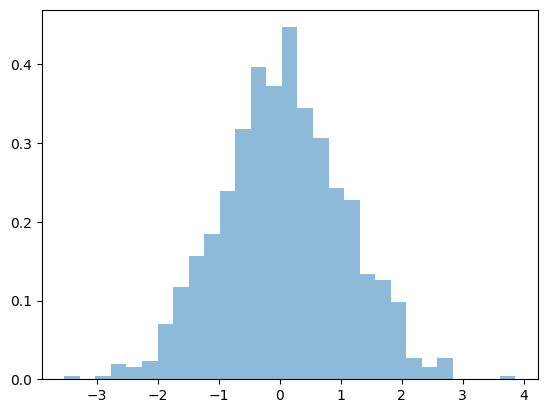

In [21]:
plt.hist(X, bins='auto', density=True, alpha=0.5, label='Generated Cauchy Distribution Samples')

In [22]:
import scipy.stats as stats
uni_needed = [x*1000 for x in uni_needed]
average_uniform_samples = np.mean(uni_needed)
ci = stats.t.interval(0.95, len(uni_needed) - 1, loc=np.mean(uni_needed), scale=stats.sem(uni_needed))
print('mean number of uniformly distributed random variables is:', average_uniform_samples)
print('Confidence Inerval is:', ci)

mean number of uniformly distributed random variables is: 1405.0
Confidence Inerval is: (1354.6770308283508, 1455.3229691716492)
